# Funkcje pomocnicze

In [1]:
import can
import matplotlib.pyplot as plt
from matplotlib import interactive
import numpy as np
import os
import time
import math
import datetime
from IPython.display import display, clear_output
from joint_can import *
%matplotlib inline

def send_msg_u(adr, data, bus, can_id = 0):
    msg = can.Message(arbitration_id=0x100 + adr + can_id, data=data, is_fd=True, is_extended_id=False)
    try:
        bus.send(msg,1)
        # print(f"Message sent on {bus.channel_info}")
    except can.CanError:
        print("Message NOT sent")
        
    return bus.recv(1)

def set_speed_u(speed, bus, can_id = 0):
    speed_data=int((speed / (math.pi * 2.0)) * 32768)
    speed_data=speed_data.to_bytes(2,'big', signed=True)
    return send_msg_u(0x000, speed_data, bus, can_id)

def get_status_u(speed, bus, can_id = 0):
    return send_msg_u(0x080, [], bus, can_id)

def extract_msg_0x01(msg):
    msg_data = list(msg.data)
    return msg_data[0]

def extract_msg_0x08(msg):
    msg_data = list(msg.data)
    return [msg_data[0], msg_data[1], msg_data[2], msg_data[3] * 256 + msg_data[4], msg_data[5] * 256 + msg_data[6], msg_data[7]]

def extract_msg_0x09(msg):
    # print(msg)
    if not (msg.arbitration_id & 0x90):
        print("blad")
    msg_data = list(msg.data)
    pz_readings = msg_data[1] * 256 + msg_data[0]
    pz_readings_counter = msg_data[5] * 256 * 256 * 256 + msg_data[4] * 256 * 256 + msg_data[3] * 256 + msg_data[2]
    pz_readings_error_counter = msg_data[9] * 256 * 256 * 256 + msg_data[8] * 256 * 256 + msg_data[7] * 256 + msg_data[6]
    pz_readings_pz_error_counter = msg_data[13] * 256 * 256 * 256 + msg_data[12] * 256 * 256 + msg_data[11] * 256 + msg_data[10]
    pz_readings_crc_error_counter = msg_data[17] * 256 * 256 * 256 + msg_data[16] * 256 * 256 + msg_data[15] * 256 + msg_data[14]
    pz_readings_lc_error_counter = msg_data[21] * 256 * 256 * 256 + msg_data[20] * 256 * 256 + msg_data[19] * 256 + msg_data[18]
    pz_readings_distance_error_counter = msg_data[25] * 256 * 256 * 256 + msg_data[24] * 256 * 256 + msg_data[23] * 256 + msg_data[22]
    pz_max_error_sequence_counter = msg_data[29] * 256 * 256 * 256 + msg_data[28] * 256 * 256 + msg_data[27] * 256 + msg_data[26]
    return [pz_readings, pz_readings_counter, pz_readings_error_counter, pz_readings_pz_error_counter, pz_readings_crc_error_counter, pz_readings_lc_error_counter, pz_readings_distance_error_counter, pz_max_error_sequence_counter]

def find_can_id(bus):
    # wyslanie ramki broadcastowej
    msg1 = send_msg(0x10, [], bus)
    # print(msg1)
    if msg1 != None:
        return msg1.arbitration_id & 0xF
    
    # wyslanie ramki unicastowej na 0x0E
    msg2 = send_msg_u(0x10, [0], bus, 0x0E)
    # print(msg2)
    if msg2 != None:
        return msg1.arbitration_id & 0xF
    
    return -1

def flush_can_bus(bus):
    for i in range(256):
        msg = bus.recv(1)
        if msg == None:
            return True
        print(f"{i} {msg}")  
    return False

def wait_until_init(bus, can_id):
    while(True):
        msg = send_msg_u(0x10, [], bus, can_id)
        fsm = extract_msg_0x01(msg)
        if fsm == 1:
            return True
        if fsm == 255:
            return False
        time.sleep(0.01)
            
def initialize_joint(bus, can_id):
    ilosc_sprawdzen = 1000
    send_msg(0x0A0, None, bus)
    time.sleep(1)

    msg = send_msg_u(0x0F0, [2, 0b11010010], bus, can_id)
    time.sleep(0.1)

    msg = send_msg_u(0x10, [1], bus, can_id)
    time.sleep(0.1)

    msg = send_msg_u(0x10, [2], bus, can_id)
    time.sleep(0.1)

    msg = send_msg_u(0x10, [3], bus, can_id)
    time.sleep(0.1)
    ilosc_krokow = 0
    while(True):
        msg = send_msg_u(0x10, [3], bus, can_id)
        fsm = extract_msg_0x01(msg)
        if fsm == 3:
            return True
        if fsm == 255:
            return False
        time.sleep(0.01)
        ilosc_krokow += 1
        if ilosc_krokow > ilosc_sprawdzen:
             return False
            
def get_register_u(register, bus, can_id = 0):
    msg = send_msg_u(0x020, [register, 1], bus, can_id)
    # print(msg)
    msg_data = list(msg.data)
    # value = int.from_bytes(msg.data[1:], byteorder='big', signed=signed)
    # print(value)
    value = msg_data[1] * 256 + msg_data[2]
    return value


def to_twos_complement(value, bits):
    if value < 0:
        value = (1 << bits) + value
    return value

def from_twos_complement(value, bits):
    if value & (1 << (bits - 1)):
        value -= (1 << bits)
    return value

def convert_to_n_bits_signed(value, n_bits):
    if value & (1 << (n_bits - 1)):
        value -= (1 << n_bits)
    return value

def aligning_error(register, value):
    error = 0xFFFF

    if (register == 'SC_GAIN'):
        error = (14.0 / 11.0) ** (value / 511)

    if (register == 'SC_PHASE'):
        error = (value / 511.0) * 11.4

    if register == 'SIN_OFF' or register == 'COS_OFF':
         error = float(value) * 0.235

    if (register == 'AI_PHASE'):
        error = value / 512.0 * 180

    if (register == 'AI_SCALE'):
        error = 1 + value / 1820.0
            
    return error


# Ustalenie CAN_ID

In [2]:
os.popen('/home/pi/mech_diagnostics/can_down.sh')
time.sleep(1)
os.popen('/home/pi/mech_diagnostics/can_up.sh')
time.sleep(1)

bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
flush_can_bus(bus)

can_id = -1
speed=-0.05 #tutaj ustawiasz predkosc w rad/s
ilosc_bledow_w_ciagu_zatrzymujaca_test=10000

_can_id = find_can_id(bus)
if _can_id >= 0:
    print(f"Znaleziono urzadzenie z adresem: {hex(_can_id)}")
    can_id = _can_id

Znaleziono urzadzenie z adresem: 0x1


# Ustal aktualne dane jointa

In [3]:
if can_id >= 0:
    # # ramka statusowa
    # msg = get_status_u(bus, can_id)
    # # ramka diagnostyczna
    # msg = send_msg_u(0x90, [], bus, can_id)
    # _data = extract_msg_0x09(msg)

    # restart
    send_msg_u(0x0A0, [], bus, can_id)
    time.sleep(0.1)

    # kalibrowanie
    send_msg_u(0x010, [131], bus, can_id)
    time.sleep(0.01)
    
    ok = wait_until_init(bus, can_id)
    if ok: 
        print("Zakonczono pomyslnie aligning")
        send_msg_u(0x040, [], bus, can_id) # Zapis w konfiguracji
        time.sleep(0.5)
        send_msg_u(0x0A0, [], bus, can_id) # restart
    else:
        print("Zakonczono aligning z bledem")
    time.sleep(0.01)
else:
    print(f"Nie znaleziono urzadzenia")

Zakonczono pomyslnie aligning


# Odczyt danych aligningu

In [4]:
if can_id >= 0:
    COS_OFF  = from_twos_complement(get_register_u(122, bus, can_id), 10)
    SIN_OFF  = from_twos_complement(get_register_u(123, bus, can_id), 10)
    SC_GAIN  = from_twos_complement(get_register_u(124, bus, can_id), 10)
    SC_PHASE = from_twos_complement(get_register_u(125, bus, can_id), 10)
    AI_PHASE = from_twos_complement(get_register_u(126, bus, can_id), 10)
    AI_SCALE = from_twos_complement(get_register_u(127, bus, can_id), 9)

    print(f"Dane kalibracyjne enkodera: COS_OFF={COS_OFF} SIN_OFF={SIN_OFF} SC_GAIN={SC_GAIN} SC_PHASE={SC_PHASE} AI_PHASE={AI_PHASE} AI_SCALE={AI_SCALE}")

    print(f"COS_OFF  value={COS_OFF} best=0 range=[{from_twos_complement( 0x200, 10)}..{from_twos_complement( 0x1FF, 10)}] [{aligning_error('COS_OFF',  COS_OFF):.3f}mV]")
    print(f"SIN_OFF  value={SIN_OFF} best=0 range=[{from_twos_complement( 0x200, 10)}..{from_twos_complement( 0x1FF, 10)}] [{aligning_error('SIN_OFF',  SIN_OFF):.3f}mV]")
    print(f"SC_GAIN  value={SC_GAIN} best=0 range=[{from_twos_complement( 0x200, 10)}..{from_twos_complement( 0x1FF, 10)}] [{aligning_error('SC_GAIN',  SC_GAIN):.3f}]")
    print(f"SC_PHASE value={SC_PHASE} best=0 range=[{from_twos_complement( 0x200, 10)}..{from_twos_complement( 0x1FF, 10)}] [{aligning_error('SC_PHASE',  SC_PHASE):.3f}°e]")

    print(f"AI_PHASE value={AI_PHASE} best=0 range=[{from_twos_complement( 0x200, 10)}..{from_twos_complement( 0x1FF, 10)}] [{aligning_error('AI_PHASE',  AI_PHASE):.3f}°e]")
    print(f"AI_SCALE value={AI_SCALE} best=0 range=[{from_twos_complement( 0x100, 9)}..{from_twos_complement( 0x0FF, 9)}] [{aligning_error('AI_SCALE',  AI_SCALE):.3f}]")
else:
    print(f"Nie znaleziono urzadzenia")

Dane kalibracyjne enkodera: COS_OFF=-38 SIN_OFF=-28 SC_GAIN=35 SC_PHASE=0 AI_PHASE=0 AI_SCALE=0
COS_OFF  value=-38 best=0 range=[-512..511] [-8.930mV]
SIN_OFF  value=-28 best=0 range=[-512..511] [-6.580mV]
SC_GAIN  value=35 best=0 range=[-512..511] [1.017]
SC_PHASE value=0 best=0 range=[-512..511] [0.000°e]
AI_PHASE value=0 best=0 range=[-512..511] [0.000°e]
AI_SCALE value=0 best=0 range=[-256..255] [1.000]


# Sprawdzenie jakości aligningiu

In [5]:
if _can_id >= 0:
    ok = initialize_joint(bus, can_id)

    data = set_speed_u(speed, bus, can_id)
    time.sleep(0.5) # czas na ustalenie stalej predkosci

    start_recording_data = False
    stop_recording_data = False

    data = []
    print(f"{datetime.datetime.now()} Start test")

    while(True):
        msg = send_msg_u(0x90, [], bus, can_id)
        _data = extract_msg_0x09(msg)
        pz_readings = _data[0]

        if (pz_readings < 10 and not start_recording_data):
            start_recording_data = True
            print(f"{datetime.datetime.now()} Start recording, current position = {pz_readings}")


        if pz_readings < 10 and start_recording_data and len(data) > 100:
            print(f"{datetime.datetime.now()} Stop recording, current position = {pz_readings}, data size={len(data)}")
            break

        if (_data[7] > ilosc_bledow_w_ciagu_zatrzymujaca_test):
            print(f"{datetime.datetime.now()} Stop recording, ERROR, max errors threshold reached = {_data[7]}")
            break

        if start_recording_data:
            data.append(_data)

        time.sleep(0.01)

    stop = set_speed_u(0., bus, can_id)
else:
    print(f"Nie wskazano urzadzenia")

2023-10-24 12:16:36.410562 Start test
2023-10-24 12:18:04.951043 Start recording, current position = 1
2023-10-24 12:20:12.652044 Stop recording, current position = 3, data size=11609


Min error rate = -0.49%
Max error rate = 100.00%
Avg error rate = 0.62%
Max error length = 130


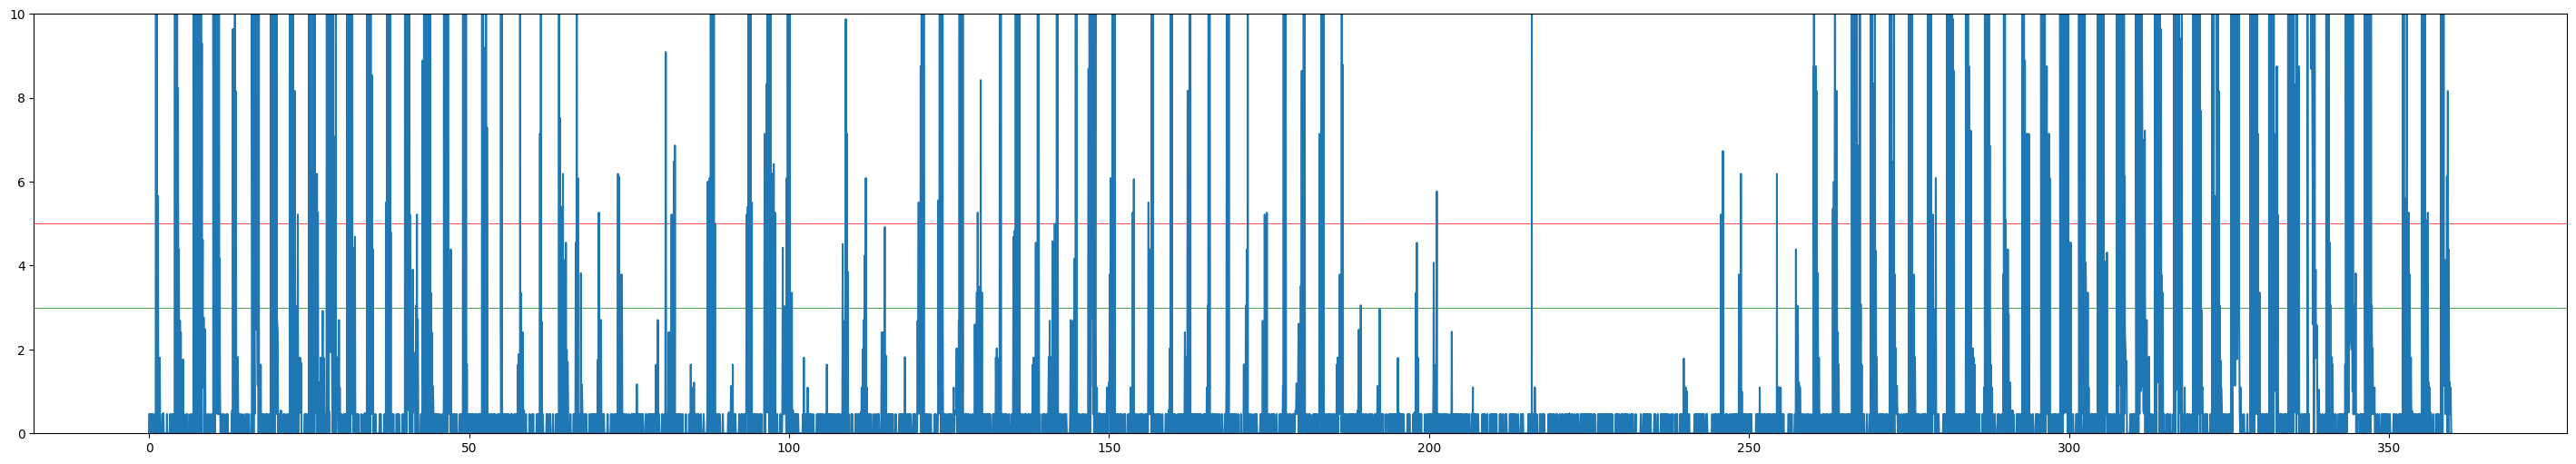

In [13]:
if len(data) > 0:
    
    x = []
    y = []

    max_error_rate = 0.0
    min_error_rate = 100.0
    avg_error_rate = 0.0

    step = 1

    for i in range(0, len(data) - step, step):
        polozenie = data[i][0] / 65536 * 360 
        x.append(polozenie)
        row = []
        ilosc_odczytow = data[i + step][1] - data[i][1]
        ilosc_bledow   = data[i + step][2] - data[i][2]
        pz_errors      = data[i + step][3] - data[i][3]

        error_rate = ilosc_bledow / ilosc_odczytow * 100
        min_error_rate = min_error_rate if min_error_rate < error_rate else error_rate 
        max_error_rate = max_error_rate if max_error_rate > error_rate else error_rate 
        row.append(error_rate)
        # print(f"{polozenie} {row} {ilosc_odczytow} {ilosc_bledow} {pz_errors} {data[i]}")
        y.append(row)

    avg_error_rate = data[-1][2] / data[-1][1] * 100
    print(f"Min error rate = { min_error_rate:.2f}%")
    print(f"Max error rate = { max_error_rate:.2f}%")
    print(f"Avg error rate = { avg_error_rate:.2f}%")
    print(f"Max error length = { data[-1][7]}")
    
    fig, ax = plt.subplots(figsize=(36,6))
    ax.plot(x, y)
    ax.axhline(y=5,xmin=0,xmax=365,c="red",linewidth=0.5,zorder=0)
    ax.axhline(y=3,xmin=0,xmax=365,c="green",linewidth=0.5,zorder=0)
    ax.set_ylim(0, 10)
    plt.show()
else:
    print(f"Brak danych")

# Zatrzymanie jointa

In [7]:
stop = set_speed_u(0.0, bus, can_id)    #zatrzymanie ctrl-enter
# print("\x1b[31m red \x1b[0m")